In [36]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

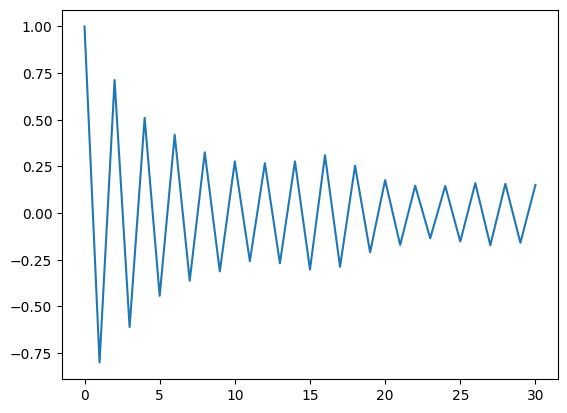

In [ ]:
np.random.seed(42)

def AR2(phi_1, phi_2, n=200):
    e = np.random.randn(n)
    X = [e[0], e[1]]

    for t in range(2, n):
        X_t = e[t]-phi_1*X[t-1]-phi_2*X[t-2]
        X.append(X_t)

    return np.array(X)


res = AR2(0.6, -0.3)

emp_acf = acf(res, nlags=30, fft=True)

plt.plot(emp_acf)
plt.show()

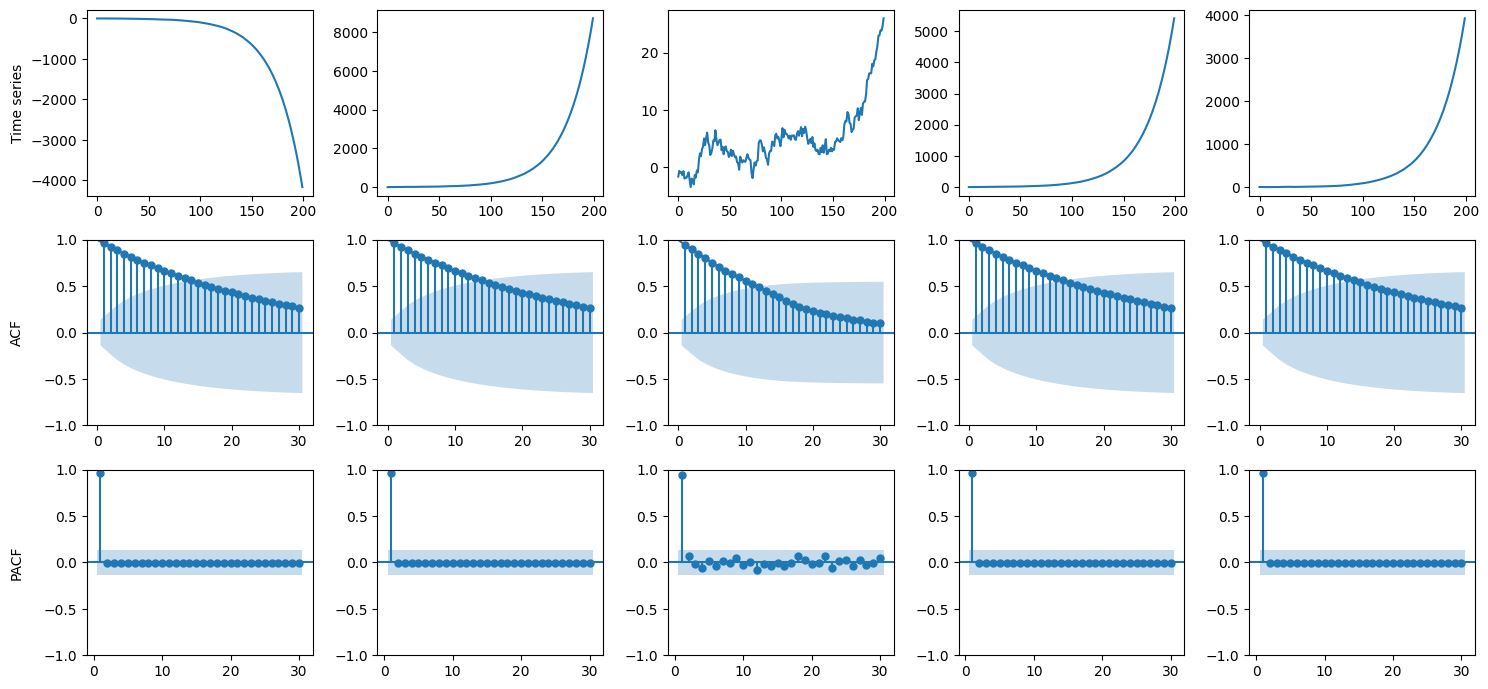

In [55]:
np.random.seed(42)

res = [AR2(-0.75, -0.3) for i in range(5)]

emp_acf = [acf(response, nlags=30, fft=True) for response in res]

fig, ax = plt.subplots(3, 5, figsize=(15, 7))

# Add row titles
# ax[0, 0].set_ylabel("Time series", labelpad=14)
ax[0, 0].set_ylabel("Time series")
ax[1, 0].set_ylabel("ACF", labelpad=14)
ax[2, 0].set_ylabel("PACF", labelpad=14)

for i, value in enumerate(res):
    ax[0, i].plot(value)
    ax[1, i].plot(emp_acf[i])
    # ax[1, i].axhline(0)
    plot_acf(res[i], lags=30, ax=ax[1, i], alpha=0.05, zero=False, color="tab:blue", title="")
    plot_pacf(res[i], lags=30, ax=ax[2, i], alpha=0.05, zero=False, color="tab:blue", title="")

plt.tight_layout()
plt.show()

# Part 2

In [56]:
import pandas as pd

In [105]:
df_solar = pd.read_csv("datasolar.csv")
np.random.seed(42)

In [123]:
Y = df_solar["power"].values

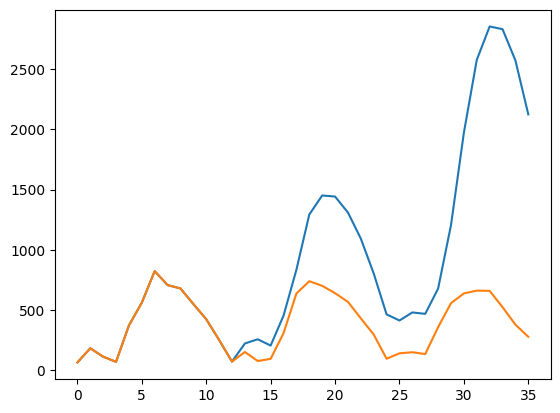

In [156]:
# np.random.seed(41)
def AR_plant(Y_t, phi=-0.38, Phi=-0.94, mu=5.74, sigma=0.22, n = 36):
    eps = np.random.randn(n) * np.sqrt(sigma)

    X = list(Y_t[:13])

    for t in range(13, n):
        X_t = -phi*X[t-1]-Phi*X[t-12]+phi*Phi*X[t-13]+eps[t]
        X.append(X_t)
    
    return np.array(X)


plt.plot(AR_plant(Y))
plt.plot(Y)
plt.show()


# Part 3

In [60]:
df_box = pd.read_csv("box_data_60min.csv")